## Testing the Reading and Manipulation of Data

This is a testbed Jupyter notebook to read in the data we need for the COVID Data Vizualization Project.

- Possible data sources that we are considering are imported and manipulated below just to provide demonstrations of how it is done.  

- I am currently using `Pandas` (aka Pythan Data Analysis Library, see https://pandas.pydata.org) to read in the CSV files and manipualte them.  This has advantages and annoyances, there may be much better ways to do this, but I was giving this a try for now.

- Some of the data includes FIPS codes (a standard geographic identifier) which should ease the process of cross-matching of data.  Clay County is 27027 and Cass County is 38017.  Minnesota is 27, North Dakota is 38.

In [20]:
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import git
import requests
from datetime import date, timedelta

In [34]:
## Define variables of interest below
data_dir = 'our_data/'    # Data directory for files we created


## US Census Data on Populations of States/Counties

This is data from the US Census Bureau estimating the population in July 2019.  Description of the file format is at https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/co-est2019-alldata.pdf

- **County Level Data**: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv
- **State Level Data**: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv



In [67]:
## Retrieve state level data (restricted to certain columns)
## When I retrieved the files, I got an error that `UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf1 in position 2: invalid continuation byte`, turns out it is encoded `latin-1`.
#census_state_csv = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"
#state_columns_of_interest = {'STATE', 'NAME', 'CENSUS2010POP', 'N_POPCHG2019', 'POPESTIMATE2019'}
#census_state_df = pd.read_csv(census_state_csv, usecols=state_columns_of_interest, encoding='latin-1')    # County totals

# Create pandas dataframes containing the selected population data for each state/county
census_county_csv = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv"
county_columns_of_interest = {'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'NPOPCHG_2019', 'POPESTIMATE2019'}
census_county_df = pd.read_csv(census_county_csv,usecols=county_columns_of_interest, encoding='latin-1')  

# Separate state level data from county level data (by creating separate copies in memory)
county_data_df = census_county_df[census_county_df['COUNTY'] != 0].copy()
state_data_df = census_county_df[census_county_df['COUNTY'] == 0].copy()

In [68]:
state_data_df

,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019,NPOPCHG_2019
0,1,0,Alabama,Alabama,4903185,15504
68,2,0,Alaska,Alaska,731545,-3594
98,4,0,Arizona,Arizona,7278717,120693
114,5,0,Arkansas,Arkansas,3017804,8071
190,6,0,California,California,39512223,50635
249,8,0,Colorado,Colorado,5758736,67449
314,9,0,Connecticut,Connecticut,3565287,-6233
323,10,0,Delaware,Delaware,973764,8285
327,11,0,District of Columbia,District of Columbia,705749,4202
329,12,0,Florida,Florida,21477737,233420


In [70]:
# Manipulate the state-leve data

# Add FIPS column for state data then DROP county data and move FIPS to first column before exporting
state_data_df['FIPS'] = state_data_df['STATE']
state_data_df.drop(columns=['STATE','COUNTY','CTYNAME'], inplace=True)
state_data_df = state_data_df.reindex(columns=(['FIPS'] + list([col for col in state_data_df.columns if col != 'FIPS']) ))

# Compute percent change in population in 2018-19
state_data_df['PPOPCHG_2019'] = 100*(state_data_df['NPOPCHG_2019']/state_data_df['POPESTIMATE2019'])

# We may want to do a daily extrapolation of population since POPESTIMATE2019 is est. population on July 1, 2019 
# and NPOPCHG_2019 is the estimated change between July 1, 2018 and July 1, 2019.  Realistically, this is probably
# overkill since the increased deaths from Coronavirus are not taken into account in such an extrapolation.

# Save the processed data file
out_states = data_dir + "population_data_states.csv"
state_data_df.to_csv(out_states)

In [71]:
# In county data create FIPS column, remove redundant columns, and then move FIPS columns to first column
county_data_df['FIPS'] = county_data_df['STATE']*1000 + county_data_df['COUNTY']
county_data_df.drop(columns=['STATE','COUNTY'], inplace=True)
county_data_df = county_data_df.reindex(columns=(['FIPS'] + list([col for col in county_data_df.columns if col != 'FIPS']) ))

# Compute percent change in population in 2018-19
county_data_df['PPOPCHG_2019'] = 100*(county_data_df['NPOPCHG_2019']/county_data_df['POPESTIMATE2019'])

# We may want to do a daily extrapolation of population since POPESTIMATE2019 is est. population on July 1, 2019 
# and NPOPCHG_2019 is the estimated change between July 1, 2018 and July 1, 2019.  Realistically, this is probably
# overkill since the increased deaths from Coronavirus are not taken into account in such an extrapolation.

# Save the processed data file
out_counties = data_dir + "population_data_counties.csv"
county_data_df.to_csv(out_counties)


In [36]:
census_county_df[(census_county_df['FIPS'] == 27027) | (census_county_df['FIPS'] == 38017)]

,FIPS,STNAME,CTYNAME,POPESTIMATE2019,NPOPCHG_2019,PPOPCHG_2019
1351,27027,Minnesota,Clay County,64222,205,0.319205
2033,38017,North Dakota,Cass County,181923,1629,0.895434


In [37]:
census_county_df[(census_county_df['CTYNAME'] == 'Minnesota') | (census_county_df['CTYNAME'] == 'North Dakota')]

,FIPS,STNAME,CTYNAME,POPESTIMATE2019,NPOPCHG_2019,PPOPCHG_2019
1337,27000,Minnesota,Minnesota,5639632,33383,0.591936
2024,38000,North Dakota,North Dakota,762062,3982,0.522530


##  Novel Coronavirus (COVID-19) Cases Data (FIPS Present)
    - https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

This dataset is part of COVID-19 Pandemic Novel Corona Virus (COVID-19) epidemiological data since 22 January 2020. The data is compiled by the Johns Hopkins University Center for Systems Science and Engineering (JHU CCSE) from various sources including the World Health Organization (WHO), DXY.cn, BNO News, National Health Commission of the People’s Republic of China (NHC), China CDC (CCDC), Hong Kong Department of Health, Macau Government, Taiwan CDC, US CDC, Government of Canada, Australia Government Department of Health, European Centre for Disease Prevention and Control (ECDC), Ministry of Health Singapore (MOH), and others. JHU CCSE maintains the data on the 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository on Github (https://github.com/CSSEGISandData/COVID-19).

In [2]:
# To make sure we have current data, I went to the directory containing this Jupyter script and 
# issued a "git clone https://github.com/CSSEGISandData/COVID-19.git" to
# pull the complete dataset from GitHub.  That created a COVID-19 directory, 
# which I renamed "JH_Data". Now it should be a short "git pull" command to keep the data up to date.

JHdata_dir = "JH_Data/"
g = git.cmd.Git(JHdata_dir)
status = g.pull()  # We should check status to see everything is good eventually, for now, I am using this to hide the status message from GitPython module

# Another choice would be to autogenerate the CSV URLs and retrieve them individually.

In [3]:
# csse_covid_19_data/csse_covid_19_daily_reports contains a daily CSV with a list of confirmed/deaths/recovered for each admin unit (in the US, that's county) for each day.
# csse_covid_19_data/csse_covid_19_daily_reports_us contains a daily CSV with list of confirmed/deaths/recovered totaled for each state (somewhat redundant, but avoids recomputation I suppose)

# Construct filename of yesterday's CSV datafile
yesterday = date.today() - timedelta(days = 1) 
yesterday_csv = f"{yesterday.month:02d}-{yesterday.day:02d}-{yesterday.year:04d}.csv"

# Build daily data filenames
daily_world_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_daily_reports/"+yesterday_csv
daily_us_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_daily_reports_us/"+yesterday_csv

# Create pandas dataframes containing the daily data from the CSV files (contains number of confirmed/deaths/recovered on that date)
daily_world_df = pd.read_csv(daily_world_csv)   # County/Admin totals
daily_us_df = pd.read_csv(daily_us_csv)         # State totals



In [139]:
daily_world_df[ (daily_world_df['FIPS'] == 1001) | (daily_world_df['FIPS'] == 38017) ]

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
106,1001.0,Autauga,Alabama,US,2020-05-28 02:32:31,32.539527,-86.644082,192,3,0,189,"Autauga, Alabama, US"
399,38017.0,Cass,North Dakota,US,2020-05-28 02:32:31,46.932017,-97.244472,1596,37,0,1559,"Cass, North Dakota, US"


In [66]:
daily_us_df[ (daily_us_df['FIPS'] == 27) | (daily_us_df['FIPS'] == 38) ]

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
27,Minnesota,US,2020-05-28 02:32:37,45.6945,-93.9002,22464,942,16314.0,5208.0,27,398.323862,216532.0,2796.0,4.193376,84000027,USA,3839.470377,12.446581
38,North Dakota,US,2020-05-28 02:32:37,47.5289,-99.7840,2439,56,1762.0,621.0,38,320.052699,67340.0,161.0,2.296023,84000038,USA,8836.551357,6.601066


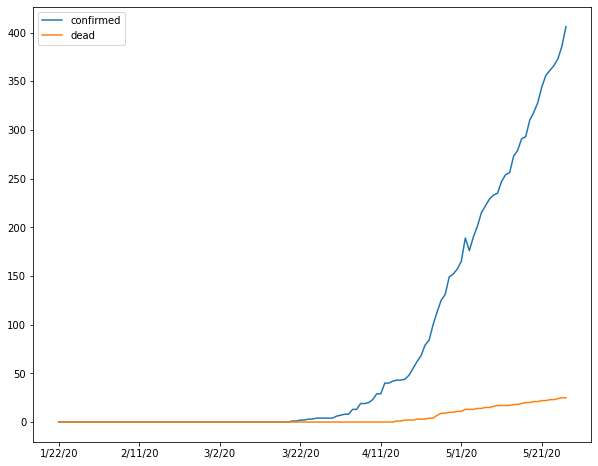

In [4]:
# Load the time series datafiles to experiment with them.

# Create pandas dataframes containing time-series data (We could reconstruct this by looping through all the daily data, since this is missing number of recovered)
ts_us_dead_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
ts_us_confirmed_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
ts_us_dead_df = pd.read_csv(ts_us_dead_csv)            # Deaths in time series
ts_us_confirmed_df = pd.read_csv(ts_us_confirmed_csv)  # Confirmed in time series

# We could transpose the dataframe to allow easier extraction of time series data on a per county level
tmp_df = ts_us_confirmed_df[ (ts_us_confirmed_df['Province_State'] == 'Minnesota') & (ts_us_confirmed_df['Admin2'] == 'Clay') ].T
tmp_df.rename(columns={ tmp_df.columns[0]: "confirmed" }, inplace = True)
confirmed_clay = tmp_df[tmp_df.index.str.match('[0-9]*/[0-9]*/[0-9]*')]  # Use pattern matching to find real dates and include

tmp_df = ts_us_dead_df[ (ts_us_confirmed_df['Province_State'] == 'Minnesota') & (ts_us_confirmed_df['Admin2'] == 'Clay') ].T
tmp_df.rename(columns={ tmp_df.columns[0]: "dead" }, inplace = True)
dead_clay = tmp_df[tmp_df.index.str.match('[0-9]*/[0-9]*/[0-9]*')] # Use pattern matching to find real dates and include

# Merge the confirmed ill and dead into one dataframe (would like recovered too, but that's not in
# these times series files)
merged_clay = confirmed_clay.merge(dead_clay, left_index=True, right_index=True)
merged_clay.plot(figsize=(10,8))

In [55]:
confirmed_clay

,confirmed
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0
...,...
5/23/20,361
5/24/20,366
5/25/20,373
5/26/20,386


## Google Mobility Data (NO FIPS Present)

This data is described at https://www.google.com/covid19/mobility/ and can be downloaded in a single monolithic CSV file at https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv

> The data shows how visitors to (or time spent in) categorized places change compared to our baseline days. A baseline day represents a normal value for that day of the week. The baseline day is the median value from the 5‑week period Jan 3 – Feb 6, 2020.

> For each region-category, the baseline isn’t a single value—it’s 7 individual values. The same number of visitors on 2 different days of the week, result in different percentage changes. So, we recommend the following:
1. Don’t infer that larger changes mean more visitors or smaller changes mean less visitors.
2. Avoid comparing day-to-day changes. Especially weekends with weekdays. (https://support.google.com/covid19-mobility/answer/9824897?hl=en&ref_topic=9822927)

> Note, *Parks* typically means official national parks and not the general outdoors found in rural areas.

In [30]:
# Google Mobility Data URL
goog_mobility_csv_url = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"
goog_mobility_df=pd.read_csv(goog_mobility_csv_url, low_memory=False)

In [31]:
goog_mobility_clay = goog_mobility_df[ (goog_mobility_df['sub_region_1'] == 'Minnesota') & (goog_mobility_df['sub_region_2'] == 'Clay County')]

# Notice for Clay county we have NaN reported for Parks (see note above) and Transit Stations
goog_mobility_clay

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
283062,US,United States,Minnesota,Clay County,2020-02-15,9.0,5.0,NaN,NaN,-1.0,NaN
283063,US,United States,Minnesota,Clay County,2020-02-16,8.0,8.0,NaN,NaN,0.0,NaN
283064,US,United States,Minnesota,Clay County,2020-02-17,1.0,5.0,NaN,NaN,-21.0,5.0
283065,US,United States,Minnesota,Clay County,2020-02-18,-1.0,0.0,NaN,NaN,-4.0,3.0
283066,US,United States,Minnesota,Clay County,2020-02-19,0.0,2.0,NaN,NaN,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
283154,US,United States,Minnesota,Clay County,2020-05-17,4.0,8.0,NaN,NaN,-25.0,NaN
283155,US,United States,Minnesota,Clay County,2020-05-18,-6.0,6.0,NaN,NaN,-37.0,12.0
283156,US,United States,Minnesota,Clay County,2020-05-19,-8.0,8.0,NaN,NaN,-36.0,13.0
283157,US,United States,Minnesota,Clay County,2020-05-20,-11.0,11.0,NaN,NaN,-37.0,13.0


## Apple Mobility Data (NO FIPS Present)

This data is described at https://www.apple.com/covid19/mobility and can be downloaded in a single monolithic CSV file at https://covid19-static.cdn-apple.com/covid19-mobility-data/2008HotfixDev42/v3/en-us/applemobilitytrends-2020-05-24.csv (That URL is hidden in the mobility page link and appears to be updated regularly.  We may need to scrape the page to identify the link).

Apple tracks three kinds of Apple Maps routing requests: Driving, Walking, Transit.  In some areas not all of these types of data are available, for example, in Clay County, only Driving route request data is available.  In fact, it looks like only driving data is available at the county level regardless of the county (at least in Minnesota). Cities can contain additional formation, although only very large cities appear to be in Apple's data files.


In [7]:
# Scraping the original Apple page was proving tricky as it had a bunch of javascript used to generate the URL, so I poked around and found a reference 
# at https://www.r-bloggers.com/get-apples-mobility-data/ to a JSON file at a stable URL that can be used to construct the appropriate URL for the current
# datafile.

aapl_mobility_json = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/v3/index.json"
aapl_server = "https://covid19-static.cdn-apple.com/"
result = requests.get(aapl_mobility_json)
# Proceed if we successfully pulled the page (HTTP status code 200)
if (result.status_code == 200):
    # Apple Mobility Data URL
    jsondata = result.json()
    aapl_mobility_csv_url = aapl_server+jsondata['basePath']+jsondata['regions']['en-us']['csvPath']
    aapl_mobility_df=pd.read_csv(aapl_mobility_csv_url, low_memory=False)

In [22]:
# Just showing how I can get clay county data specifically
aapl_mobility_minneapolis = aapl_mobility_df[(aapl_mobility_df['region'] == 'Minneapolis') & (aapl_mobility_df['sub-region'] == 'Minnesota')]
aapl_mobility_clay = aapl_mobility_df[(aapl_mobility_df['region'] == 'Clay County') & (aapl_mobility_df['sub-region'] == 'Minnesota')]

In [62]:
# Notice only driving information is available here
aapl_mobility_clay

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26
1909,county,Clay County,driving,NaN,Minnesota,United States,100.0,92.08,85.04,105.88,...,105.01,124.88,122.92,135.87,136.6,167.14,140.23,104.41,118.58,133.72


In [27]:
# Notice additional information is available for larger cities
aapl_mobility_cities = aapl_mobility_df[(aapl_mobility_df['geo_type'] == 'city') & (aapl_mobility_df['country'] == 'United States')]
aapl_mobility_cities

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26
158,city,Akron,driving,NaN,Ohio,United States,100.0,103.06,107.50,106.14,...,94.21,108.57,119.76,123.50,129.05,135.56,130.72,104.99,96.83,131.00
159,city,Akron,transit,NaN,Ohio,United States,100.0,106.69,103.75,100.22,...,30.88,45.00,43.75,47.50,46.99,51.10,54.41,35.74,36.99,63.09
160,city,Akron,walking,NaN,Ohio,United States,100.0,97.23,79.05,74.77,...,83.86,86.90,94.93,94.67,100.19,108.84,106.54,84.12,72.99,104.32
161,city,Albany,driving,NaN,New York,United States,100.0,102.35,107.35,105.54,...,75.35,83.97,92.49,96.26,101.83,114.11,95.16,80.05,79.79,98.02
162,city,Albany,transit,NaN,New York,United States,100.0,100.14,105.95,107.76,...,44.91,56.06,56.62,55.04,54.34,55.46,54.67,45.84,52.07,55.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,city,Washington DC,walking,DC,NaN,United States,100.0,99.07,109.61,104.16,...,56.19,56.13,57.97,58.64,59.88,64.81,80.41,61.40,65.83,65.43
927,city,Wichita,driving,NaN,Kansas,United States,100.0,104.78,105.49,105.77,...,98.73,131.00,137.68,137.95,134.99,158.55,144.12,106.15,97.54,135.84
928,city,Wichita,walking,NaN,Kansas,United States,100.0,115.79,118.87,114.70,...,141.14,163.49,183.25,180.01,160.17,193.79,175.38,143.38,114.51,159.48
931,city,Worcester,driving,NaN,Massachusetts,United States,100.0,106.80,108.53,109.14,...,73.90,79.84,87.67,92.81,98.16,110.34,90.87,81.51,76.73,98.96


## IMHE Data on Local Resources

There is IMHE data on local resources at http://www.healthdata.org/covid/data-downloads although I am not sure that data is available with county level resolution as I haven't fully investigated it yet.

## NY Times Data on Probable Deaths/Cases (FIPS Present)

The NY Times has assembled data on COVID in a GitHub repository at https://github.com/nytimes/covid-19-data.  I have not examined that data yet, but it may well be interesting.

Note their statement requiring credit:

> In light of the current public health emergency, The New York Times Company is
providing this database under the following free-of-cost, perpetual,
non-exclusive license. Anyone may copy, distribute, and display the database, or
any part thereof, and make derivative works based on it, provided  (a) any such
use is for non-commercial purposes only and (b) credit is given to The New York
Times in any public display of the database, in any publication derived in part
or in full from the database, and in any other public use of the data contained
in or derived from the database.

Data is available at county, state, and national levels for live numbers (current cases/deaths as well as probable cases/deaths, updated daily).  That said, at least locally I don't think Probable cases are really making a difference.


In [28]:
# Update the NYT Datafiles
NYTdata_dir = "NYT_Data/"
g = git.cmd.Git(NYTdata_dir)
status = g.pull()  # We should check status to see everything is good eventually, for now, I am using this to hide the status message from GitPython module

In [40]:
# Grab the live data files
live_county_csv = NYTdata_dir+"live/us-counties.csv"
live_state_csv = NYTdata_dir+"live/us-states.csv"
live_us_csv = NYTdata_dir+"live/us.csv"

# Create pandas dataframes containing the daily data from the CSV files (contains number of confirmed/deaths/recovered on that date)
live_county_df = pd.read_csv(live_county_csv)   # County totals
live_state_df = pd.read_csv(live_state_csv)    # State totals
live_us_df = pd.read_csv(live_us_csv)       # National totals


In [54]:
live_county_df[ ((live_county_df['state'] == 'Minnesota') & (live_county_df['county'] == 'Clay')) | ((live_county_df['state'] == 'North Dakota') & (live_county_df['county'] == 'Cass')) ]

,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
1284,2020-05-28,Clay,Minnesota,27027.0,406,25.0,406.0,25.0,NaN,NaN
1886,2020-05-28,Cass,North Dakota,38017.0,1596,45.0,1596.0,45.0,NaN,NaN


In [42]:
live_state_df[ (live_state_df['state'] == 'Minnesota')]

,date,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
24,2020-05-28,Minnesota,27,22474,942,22464.0,932.0,10.0,10.0


In [52]:
live_us_df

,date,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
0,2020-05-28,1709688,100520,NaN,NaN,NaN,NaN
